In [1]:
# create dataset
import pandas as pd
base_dir = 'data/McGill-Billboard'
data_index = 'billboard-2.0-manychords.csv'

df_songs = pd.read_csv(f'{base_dir}/{data_index}')
df_songs.set_index('id', inplace=True)
len(df_songs)

719

In [2]:
df_songs.head(n=3)

,title,artist,no_chord_percent
id,,,
3,I Don't Mind,James Brown,0.049747
4,You've Got A Friend,"Roberta Flack,Donny Hathaway",0.050770
6,The Rose,Bette Midler,0.117244


In [3]:
test_ids = [1289, 736, 637, 270, 18] # songs to exclude for testing
df_dataset = df_songs.drop(index=test_ids)
len(df_dataset)

714

In [4]:
import numpy as np
_SEED = 0

df_idxs = np.array(df_dataset.index.values)
rng = np.random.default_rng(_SEED)
rng.shuffle(df_idxs)

df_idxs[:10]

array([1167,    6,  986,  227,  743,  568,  107,  181,   27,  793])

In [ ]:
from dataloader import QueueData

_NUM_VAL_SONGS = 100

QueueData(dataset=df_idxs)

Since minimum counts is ~20000, w/c is already a lot, we can get maybe around 1000 from each class as test set, 4000 from each class as validation set on 5 different splits, splits w/o overlapping data points.

#### Splitting

In [2]:
from numpy.random import default_rng

_SEED = 0

# test; must always return same result in successive runs
x = [1,2,3,4,5,6,7,8,9]
rng = default_rng(seed=_SEED)
rng.shuffle(x)

# re-seeding allows to get similar shuffles for diff.arrays
y = [11,22,33,44,55,66,77,88,99]
rng = default_rng(seed=_SEED)
rng.shuffle(y)

z = [0,1,2,3,4,5,6,7,8]
rng = default_rng(seed=_SEED)
rng.shuffle(z)

x, y, z

([5, 6, 3, 7, 4, 9, 8, 1, 2],
 [55, 66, 33, 77, 44, 99, 88, 11, 22],
 [4, 5, 2, 6, 3, 8, 7, 0, 1])

In [3]:
def shuffle_set(array_set):
    """ Shuffle in unison all arrays in array_set """
    for arr in array_set:
        rng = default_rng(seed=_SEED)
        rng.shuffle(arr)
    
    return array_set

x = [1,2,3,4,5,6,7,8,9]
y = [11,22,33,44,55,66,77,88,99]
z = [0,1,2,3,4,5,6,7,8]
x,y,z = shuffle_set((x,y,z))

x,y,z

([5, 6, 3, 7, 4, 9, 8, 1, 2],
 [55, 66, 33, 77, 44, 99, 88, 11, 22],
 [4, 5, 2, 6, 3, 8, 7, 0, 1])

We'll shuffle first before splitting to add some randomness in the data.

In [33]:
import numpy as np

_NUM_TEST_PER_CLASS = 1 #1000
_NUM_VAL_PER_CLASS = 4 #4000
_NUM_VAL_SPLITS = 5

class QueueData():
    def __init__(self, dataset):
        self.dataset = dataset
        self.st_ix = 0
    
    def take(self, num):
        st, ed = self.st_ix, self.st_ix+num
        queue_out = tuple(data[st:ed] for data in self.dataset)
        self.st_ix = ed
        return queue_out
    
    def flush(self):
        st, ed = self.st_ix, len(self.dataset[0])
        queue_out = tuple(data[st:ed] for data in self.dataset)
        return queue_out

class SplitData():
    def __init__(self, feats=None, labels=None):
        self.feats = feats
        self.labels = labels
        
    def push(self, feats, labels):
        assert(len(feats)==len(labels))
        if self.feats is None:
            self.feats = feats
        else:
            self.feats = np.concatenate((self.feats, feats))
        
        if self.labels is None:
            self.labels = labels
        else:
            self.labels = np.concatenate((self.labels, labels))
    
    def __len__(self):
        return len(self.labels)

    @property
    def shape(self):
        return (self.feats.shape, self.labels.shape)

def get_splits(feats, labels, validate=True):
    """ Return training, validation, and test sets """
    classes = list(set(labels))
    classes.sort()
    
    if validate:
        hist, _ = np.histogram(labels, bins=classes)
        assert(min(hist) >= (_NUM_TEST_PER_CLASS + (_NUM_VAL_SPLITS*_NUM_VAL_PER_CLASS)))
    
    test_split = SplitData()
    val_splits = [SplitData() for i in range(_NUM_VAL_SPLITS)]
    train_split = SplitData()
    
    for cls in classes:
        mask = (labels==cls)
        queue = QueueData(dataset=(feats[mask], labels[mask]))
        
        test_split.push(*queue.take(_NUM_TEST_PER_CLASS))
        for ix in range(_NUM_VAL_SPLITS):
            val_splits[ix].push(*queue.take(_NUM_VAL_PER_CLASS))
        train_split.push(*queue.flush())

    return train_split, val_splits, test_split

train_split, val_splits, test_split = get_splits(all_chroma_vectors[:100], all_chord_labels[:100])

In [18]:
print(train_split.shape)
for val_split in val_splits:
    print(val_split.shape)
print(test_split.shape)

((58, 24), (58,))
((8, 24), (8,))
((8, 24), (8,))
((8, 24), (8,))
((8, 24), (8,))
((8, 24), (8,))
((2, 24), (2,))


In [19]:
_NUM_TEST_PER_CLASS = 1000
_NUM_VAL_PER_CLASS = 4000
_NUM_VAL_SPLITS = 5

all_chroma_vectors, all_chord_labels = shuffle_set((all_chroma_vectors, all_chord_labels))
train_split, val_splits, test_split = get_splits(all_chroma_vectors, all_chord_labels)

print(train_split.shape)
for val_split in val_splits:
    print(val_split.shape)
print(test_split.shape)

((2835513, 24), (2835513,))
((100000, 24), (100000,))
((100000, 24), (100000,))
((100000, 24), (100000,))
((100000, 24), (100000,))
((100000, 24), (100000,))
((25000, 24), (25000,))


In [44]:
def get_next_cv_split(train_split, val_splits):
    num_cv = len(val_splits)
    for v_ix in range(num_cv): # index of val split at a specific round
        addl_train_splits = val_splits[0:v_ix] + val_splits[v_ix+1:]
        val_split = val_splits[v_ix]
        
        full_train_feats = np.concatenate((train_split.feats,
                                           *[split.feats for split in addl_train_splits]))
        full_train_labels = np.concatenate((train_split.labels,
                                            *[split.labels for split in addl_train_splits]))
        full_train_split = SplitData(feats=full_train_feats,labels=full_train_labels)
        yield full_train_split, val_split
            
        
for train, val in get_next_cv_split(train_split, val_splits):
    print(len(train), len(val))

3235513 100000
3235513 100000
3235513 100000
3235513 100000
3235513 100000


Try with the dataloader module

In [1]:
from dataloader import SimpleChromaDataset

ds = SimpleChromaDataset(feat_label_files=('data/01_all_chroma_vectors.npy',
                                           'data/01_all_chord_labels.npy'))

Loaded features and labels.
Split into train, val, test.


In [2]:
for train, val in ds.get_next_cv_split():
    print(len(train), len(val))

3235513 100000
3235513 100000
3235513 100000
3235513 100000
3235513 100000


#### Feature check

/home/cjbayron/virtualenvs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  import sys


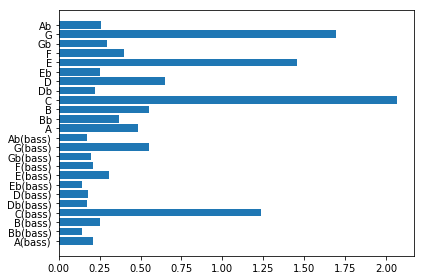

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from dataloader import _CHROMA_FEAT_NAMES
%matplotlib inline

filt = [train.labels == 1] # c maj
plt.barh(range(24), np.mean(train.feats[filt], axis=0))
plt.yticks(range(24), _CHROMA_FEAT_NAMES)
plt.tight_layout()

### Training loop

In [15]:
from dataloader import SimpleChromaDataset

ds = SimpleChromaDataset(feat_label_files=('data/01_all_chroma_vectors.npy',
                                           'data/01_all_chord_labels.npy'))

Loaded features and labels.
Split into train, val, test.


<hr style="border:1px solid gray">

#### Colab prep

In [ ]:
!pip install hyperopt
!pip install guildai # restart after install

In [ ]:
# colab prep
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!cp /content/drive/MyDrive/colab-handover/autochord/* ./
!ls

In [ ]:
from dataloader import SimpleChromaDataset

ds = SimpleChromaDataset(feat_label_files=('01_all_chroma_vectors.npy',
                                           '01_all_chord_labels.npy'))

<hr style="border:1px solid gray">

In [16]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import accuracy_score, f1_score
import tensorflow as tf
from tensorflow.keras import layers
from dataloader import _CHROMA_FEAT_NAMES

def K_plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

/home/cjbayron/virtualenvs/pytorch/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/home/cjbayron/virtualenvs/pytorch/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/home/cjbayron/virtualenvs/pytorch/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/cjbayron/virtualenvs/pytorch/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [17]:
_SEED = 0
_EPOCHS = 2 #10
_BATCH_SIZE = 32 #512
_CKPT_PATH = 'models/simple-chroma-{cv}'

def init_simple_model(base_linear_units=256, dropout=0.6, opt='adam', lr=0.01):
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(len(_CHROMA_FEAT_NAMES),)),
        layers.Dense(units=base_linear_units, activation='relu'),
        layers.Dropout(rate=dropout),
        layers.Dense(units=base_linear_units*4, activation='relu'),
        layers.Dropout(rate=dropout),
        layers.Dense(units=base_linear_units, activation='relu'),
        layers.Dense(units=ds.n_class, activation='softmax'),
    ])

    opt = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=opt,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

def sample_train_loop(ds):
    # cross validation loop
    tf.random.set_seed(_SEED)
    for cv_ix, (train, val) in enumerate(ds.get_next_cv_split()):
        print(f'----------- CV{cv_ix+1} -----------')
        train_dataset = tf.data.Dataset.from_tensor_slices((train.feats, train.labels)) \
                                       .take(100) \
                                       .shuffle(buffer_size=len(train), seed=_SEED, reshuffle_each_iteration=True) \
                                       .batch(_BATCH_SIZE)
        val_dataset = tf.data.Dataset.from_tensor_slices((val.feats, val.labels)) \
                                     .take(100) \
                                     .shuffle(buffer_size=len(val), seed=_SEED, reshuffle_each_iteration=True) \
                                     .batch(_BATCH_SIZE)

        print(f'Num train: {len(train)}, Num val: {len(val)}')
        assert(train.feats.shape[-1] == val.feats.shape[-1])
        print(f'Input features: {train.feats.shape[-1]}, Num classes: {ds.n_class}')
        
        model = init_simple_model()
        history = model.fit(train_dataset, validation_data=val_dataset, epochs=_EPOCHS)

        # get F1 score
        pred_chord_ixs = np.argmax(model.predict(val.feats, batch_size=_BATCH_SIZE), axis=1)
        print(f"val_fscore: {f1_score(y_true=val.labels, y_pred=pred_chord_ixs, average='macro')}")
        K_plot_loss(history)

        model.save(_CKPT_PATH.format(cv=cv_ix))

        break

sample_train_loop(ds)

**Manual tracking**

1. 256, 0.6, `Adam (0.01)` - `val loss: 3.2, val acc: 12.98%`
2. 1024, 0.6, `Adam (0.001)` - 

#### Automated tuning & tracking

In [ ]:
# colab
!cp -R /content/drive/MyDrive/colab-handover/autochord/guild-env-colab ./

In [9]:
from IPython.display import display

GUILD_HOME = 'guild-env/simple-chroma' # "guild-env-colab/simple-chroma"
DELETE_RUNS_ON_INIT = False
import guild.ipy as guild
guild.set_guild_home(GUILD_HOME)

if DELETE_RUNS_ON_INIT:
    deleted = guild.runs().delete(permanent=True)
    print("Deleted %i run(s)" % len(deleted))
else:
    display(guild.runs().head())

,run,operation,started,status,label
0,ff8c9ad6,hpset_trainloop(),2021-05-23 05:53:50,completed,bs=512 dp=0.6 hd=256 lr=0.001 opt=adam si=4
1,5d15565c,hpset_trainloop(),2021-05-23 05:52:48,completed,bs=512 dp=0.6 hd=256 lr=0.001 opt=adam si=3
2,856f7a7f,hpset_trainloop(),2021-05-23 05:51:46,completed,bs=512 dp=0.6 hd=256 lr=0.001 opt=adam si=2
3,66da07ec,hpset_trainloop(),2021-05-23 05:50:44,completed,bs=512 dp=0.6 hd=256 lr=0.001 opt=adam si=1
4,6f21924d,hpset_trainloop(),2021-05-23 05:49:43,completed,bs=512 dp=0.6 hd=256 lr=0.001 opt=adam si=0


In [29]:
_EPOCHS = 5
_TRAIN = None
_VAL = None

# function for guild tracking
def hpset_trainloop(hd=256, dp=0.6, opt='adam', lr=0.001, bs=512, si=0):
    '''
    Train loop with a specific set of hyperparams
    
    hd: hidden dim base size
    dp: dropout rate
    opt: optimizer, lr: learning rate
    bs: batch size
    si: CV split index
    '''
    tf.random.set_seed(_SEED)
    train = _TRAIN
    val = _VAL
    if (not train) or (not val):
        raise Exception("Missing data!")
    
    train_dataset = tf.data.Dataset.from_tensor_slices((train.feats, train.labels)) \
                                   .take(100) \
                                   .shuffle(buffer_size=len(train), seed=_SEED, reshuffle_each_iteration=True) \
                                   .batch(bs)
    val_dataset = tf.data.Dataset.from_tensor_slices((val.feats, val.labels)) \
                                 .take(100) \
                                 .shuffle(buffer_size=len(val), seed=_SEED, reshuffle_each_iteration=True) \
                                 .batch(bs)

    assert(train.feats.shape[-1] == val.feats.shape[-1])

    model = init_simple_model(base_linear_units=hd, dropout=dp, opt=opt, lr=lr)
    history = model.fit(train_dataset, validation_data=val_dataset, epochs=_EPOCHS, verbose=0)
    
    best_epoch = np.argmax(history.history['val_accuracy'])
    best_acc = history.history['val_accuracy'][best_epoch]
    
    # output metrics
    print(f"BE: {best_epoch+1}")
    print(f"VA: {best_acc}")
    
    return best_acc

In [ ]:
# tuning loop
from hyperopt import hp, tpe, fmin

def tuning_loop(hparams):
    global _TRAIN
    global _VAL
    
    print(hparams)

    avg_acc = 0.0
    num_runs = 0
    for cv_ix, (train, val) in enumerate(ds.get_next_cv_split()):
        _TRAIN = train
        _VAL = val
        run, acc = guild.run(hpset_trainloop,
                             hd=int(hparams['base_hidden_dim']),
                             dp=hparams['drop_rate'],
                           opt=hparams['opt'],
                             lr=hparams['lr'], 
                             bs=int(hparams['batch_size']),
                             si=cv_ix)
        
        num_runs += 1
        # if hyperparams fail miserably on one split,
        # no need to check other splits
        if acc < 0.5:
            return 1.0
            
        avg_acc += acc
    
    avg_acc /= num_runs
    return (1-avg_acc) # since we're using fmin

hparams = {
    'base_hidden_dim': hp.choice('base_hidden_dim', [256, 512, 1024]),
    'drop_rate': hp.choice('drop_rate', [0.9, 0.7, 0.5, 0.3]),
    'opt': hp.choice('opt', ['adam']),
    'lr': hp.choice('lr', [1e-2, 1e-3, 3e-4, 1e-4]),
    'batch_size': hp.choice('batch_size', [16, 32, 64]),
}

best = fmin(tuning_loop, hparams, algo=tpe.suggest, max_evals=1)
print(best)

In [ ]:
# colab
!cp -R guild-env-colab /content/drive/MyDrive/colab-handover/autochord/

In [18]:
runs = guild.runs()
df_exps = runs.compare()

_COMPARE_COLS = ['bs','dp','hd','lr','opt','si','BE','VA']
comps = df_exps[_COMPARE_COLS][:65]
comps[comps.VA > 0.52]

,bs,dp,hd,lr,opt,si,BE,VA
9,256,0.6,256,0.0003,adam,0,2.0,0.52030
12,512,0.3,256,0.0003,adam,2,2.0,0.52078
17,512,0.3,512,0.0003,adam,2,1.0,0.52138
36,256,0.5,256,0.0001,adam,3,2.0,0.52239
37,256,0.5,256,0.0001,adam,2,1.0,0.52428
39,256,0.5,256,0.0001,adam,0,2.0,0.52686
51,256,0.5,256,0.0003,adam,0,1.0,0.52050
53,256,0.5,256,0.0001,adam,0,2.0,0.52666


#### Scratch

In [ ]:
import numpy as np

# try limiting class
ds.chroma_vectors = np.load('01_all_chroma_vectors.npy')
ds.chord_labels = np.load('01_all_chord_labels.npy')
filt = np.isin(ds.chord_labels, (0,1))
ds.chroma_vectors = ds.chroma_vectors[filt]
ds.chord_labels = ds.chord_labels[filt]
ds.classes = set(ds.chord_labels)
ds.n_class = len(ds.classes)
print('Loaded features and labels.')
ds.train_split, ds.val_splits, ds.test_split = ds.get_splits()
print('Split into train, val, test.')
print(ds.n_class)

In [10]:
print(ds.chroma_vectors[0], ds.chord_labels[0])
print(ds.chroma_vectors[-113], ds.chord_labels[-113])

[0.198482  0.        0.        0.635556  0.741292  1.0043    0.81444
 0.0292819 0.141189  0.80793   0.91015   0.823603  1.22066   0.0969013
 0.197437  0.860228  1.16515   1.13561   0.42842   0.112475  1.49297
 0.556156  0.562561  0.864485 ] 0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 17


In [33]:
filt = [ds.chord_labels == 0]
np.mean(ds.chroma_vectors[filt], axis=0)

/home/cjbayron/virtualenvs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  


array([0.32049295, 0.24610202, 0.28693406, 0.25687285, 0.20151652,
       0.29747371, 0.20591433, 0.27151966, 0.22509008, 0.21612551,
       0.26522816, 0.21338926, 0.7405679 , 0.48997662, 0.60600057,
       0.60080249, 0.48543003, 0.73010563, 0.44549839, 0.73231232,
       0.53258909, 0.54258336, 0.6778894 , 0.48055285])

In [34]:
filt = [ds.chord_labels == 1]
np.mean(ds.chroma_vectors[filt], axis=0)

/home/cjbayron/virtualenvs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  


array([0.20761943, 0.14172344, 0.25146699, 1.23340365, 0.1735976 ,
       0.17857491, 0.14191071, 0.30587265, 0.20928596, 0.19817245,
       0.54753261, 0.16978452, 0.48747069, 0.36887956, 0.55286642,
       2.05746208, 0.21877638, 0.64896599, 0.25239646, 1.45968816,
       0.40032339, 0.2984598 , 1.69132596, 0.2568249 ])

In [21]:
filt = [np.sum(ds.chroma_vectors, axis=1) == 0]

In [24]:
from collections import Counter
Counter(ds.chord_labels[filt])

/home/cjbayron/virtualenvs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  


Counter({0: 49874,
         2: 203,
         8: 537,
         22: 150,
         13: 51,
         6: 464,
         7: 249,
         12: 330,
         9: 192,
         4: 141,
         24: 34,
         1: 399,
         17: 97,
         15: 244,
         10: 434,
         5: 547,
         14: 77,
         3: 414,
         11: 269,
         20: 80,
         18: 140,
         23: 21,
         16: 141,
         19: 29,
         21: 1})

In [11]:
history.history['loss'][-1]

0.03958175703883171

In [6]:
# test loading
m = tf.keras.models.load_model(_CKPT_PATH.format(cv=0))
m.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 256)               6400      
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1024)              263168    
_________________________________________________________________
dropout_3 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               262400    
_________________________________________________________________
dense_7 (Dense)              (None, 25)                6425      
Total params: 538,393
Trainable params: 538,393
Non-trainable params: 0
________________________________________________

In [ ]:
# add callbacks
# add tuning
# mind the seeding!